In [0]:
!pip install -q keras

# DeepFashion category transfer learning

## Data preparation

In [0]:
from google.colab import drive
drive.mount('/mnt/gdrive')

In [0]:
FOLDER = '/mnt/gdrive/My Drive/Abraia/Datasets/DeepfashionClothingCategory/'

In [0]:
%%capture
!unzip '/mnt/gdrive/My Drive/Abraia/Datasets/DeepfashionClothingCategory/img.zip'

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_cat_img = pd.read_csv(os.path.join(FOLDER, 'list_category_img.txt'), delim_whitespace=1, header=1)
df_cat_cloth = pd.read_csv(os.path.join(FOLDER, 'list_category_cloth.txt'), delim_whitespace=1, header=1)
df_eval_part = pd.read_csv(os.path.join(FOLDER, 'list_eval_partition.txt'), delim_whitespace=1, header=1)
df_bbox_img = pd.read_csv(os.path.join(FOLDER, 'list_bbox.txt'), delim_whitespace=1, header=1)

df_images = pd.merge(df_cat_img, df_eval_part, on='image_name')
df_images = pd.merge(df_images, df_bbox_img, on='image_name')
df_categories = df_cat_cloth

Analize data from the dataset.

Text(0, 0.5, 'Test counts')

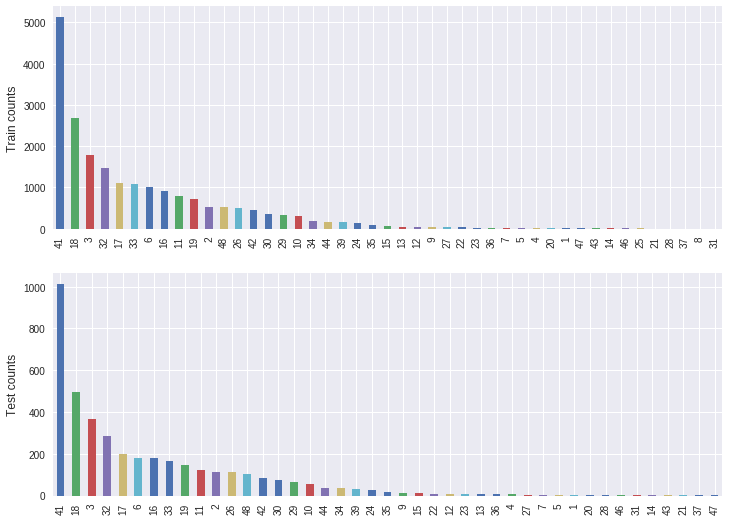

In [0]:
train = df_images[df_images.evaluation_status == 'train'].sample(frac=0.1)
test = df_images[df_images.evaluation_status == 'test'].sample(frac=0.1)

train_counts = train.category_label.value_counts()
test_counts = test.category_label.value_counts()

plt.figure(figsize=(12, 9))
plt.subplot(211)
train_counts.plot(kind='bar', ax=plt.gca())
plt.ylabel('Train counts', fontsize=12)
plt.subplot(212)
test_counts.plot(kind='bar', ax=plt.gca())
plt.ylabel('Test counts', fontsize=12)

In [0]:
CATEGORIES = [41, 18, 3, 32, 17, 33, 16, 11, 26, 30]
samples = min([train_counts[cat] for cat in CATEGORIES])
print([df_cat_cloth.category_name.iloc[cat-1] for cat in CATEGORIES])

['Dress', 'Tee', 'Blouse', 'Shorts', 'Tank', 'Skirt', 'Sweater', 'Jacket', 'Jeans', 'Leggings']


Move files to train and test folders.

In [0]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'

def link_images(data, dir):
    samples = min([data.category_label.value_counts()[cat] for cat in CATEGORIES])
    if not os.path.exists(dir):
        os.mkdir(dir)
    for cat in CATEGORIES:
        category = df_cat_cloth.category_name.iloc[cat-1]
        folder = os.path.join(dir, str(category))
        if not os.path.exists(folder):
            os.mkdir(folder)
        paths = data[data.category_label == cat].image_name.values
        #paths = data[data.category_label == cat].sample(samples).image_name.values
        for k, path in enumerate(paths):
            os.symlink(os.path.join(os.getcwd(), path), os.path.join(folder, '{:05d}.jpg'.format(k)))
        
link_images(train, TRAIN_DIR)
link_images(test, TEST_DIR)

Plot some random images from the dataset.

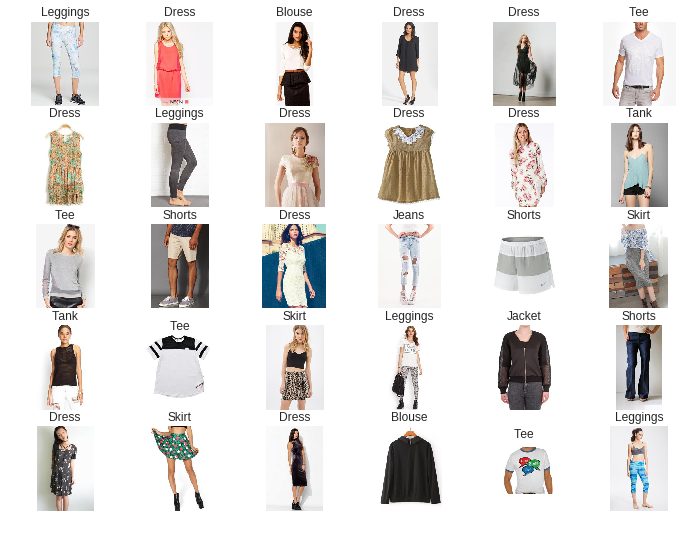

In [0]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

N, R, C = 30, 5, 6

data = np.random.choice(glob.glob('train/*/*.jpg'), N)
labels = [os.path.dirname(path).split('/')[-1] for path in data]

plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Data augmentation

In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    fill_mode='nearest')

Using TensorFlow backend.


In [0]:
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 15849 images belonging to 10 classes.
Found 3016 images belonging to 10 classes.


Plot some images result of data augmentation.

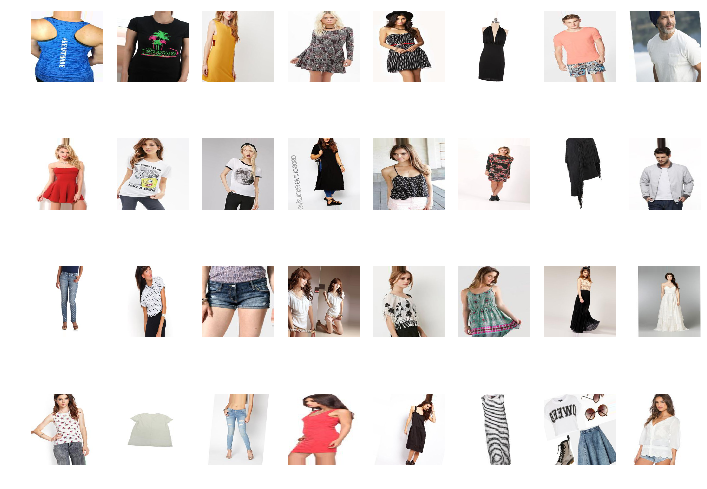

In [0]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Model customization

In [0]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = len(CATEGORIES)

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


## Transfer learning

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [0]:
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
EPOCHS = 6

STEPS_PER_EPOCH = 512
VALIDATION_STEPS = 64

MODEL_FILE = os.path.join(FOLDER, 'model.h5')

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, early])
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
512/512 [==============================] - 449s 876ms/step - loss: 1.6766 - acc: 0.4760 - val_loss: 1.1767 - val_acc: 0.6118

Epoch 00001: val_acc improved from -inf to 0.61182, saving model to model.h5
Epoch 2/6
512/512 [==============================] - 434s 847ms/step - loss: 1.3085 - acc: 0.5572 - val_loss: 1.3537 - val_acc: 0.5894

Epoch 00002: val_acc did not improve from 0.61182
Epoch 3/6
512/512 [==============================] - 431s 841ms/step - loss: 1.2273 - acc: 0.5833 - val_loss: 1.1934 - val_acc: 0.6141

Epoch 00003: val_acc improved from 0.61182 to 0.61413, saving model to model.h5
Epoch 4/6
512/512 [==============================] - 429s 838ms/step - loss: 1.2003 - acc: 0.5901 - val_loss: 1.3290 - val_acc: 0.6055

Epoch 00004: val_acc did not improve from 0.61413
Epoch 5/6
250/512 [=============>................] - ETA: 3:25 - loss: 1.1822 - acc: 0.5972

## Fine-tuning

In [0]:
# We chose to train the top 2 inception blocks, i.e. we will freeze the first
# 249 layers and unfreeze the rest, according to https://keras.io/applications/#inceptionv3
# In other examples found it was 172 insted 249
layer_num = len(model.layers)
for layer in model.layers[:249]:
    layer.trainable = False

# fine-tuning
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
EPOCHS = 3

STEPS_PER_EPOCH = 512
VALIDATION_STEPS = 64

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, early])
  
model.save(MODEL_FILE)

Epoch 1/3
507/512 [============================>.] - ETA: 4s - loss: 0.9902 - acc: 0.6628

## Results test

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)

In [0]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix

test_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=3000,
    class_mode='categorical')

labels = [label for label, value in test_generator.class_indices.items()]

x_test, y_test = next(test_generator)

y_pred = model.predict(x_test)

cm = confusion_matrix(np.argmax(y_test, axis=1)+1, np.argmax(y_pred, axis=1)+1)
#cm = cm / np.sum(cm)

plot_confusion_matrix(cm, classes=labels)

In [0]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(np.argmax(y_test, axis=1)+1, np.argmax(y_pred, axis=1)+1)
f1 = f1_score(np.argmax(y_test, axis=1)+1, np.argmax(y_pred, axis=1)+1, average='weighted')
acc, f1

## Prediction of the custom model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model

labels = [label for label, value in validation_generator.class_indices.items()]

def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds, title=''):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 2])
    plt.figure(figsize=(12, 9))
    plt.subplot(gs[0])
    plt.title(title, fontsize=20)
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(range(len(preds)), preds, alpha=0.5)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [0]:
model = load_model(MODEL_FILE)

In [0]:
file = np.random.choice(glob.glob('test/*/*.jpg'))
img = image.load_img(file, target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

label = os.path.dirname(file).split('/')[-1]
plot_preds(np.asarray(img), preds, title=label)
print(np.max(preds), labels[np.argmax(preds)], file)